In [1]:
using Pkg
Pkg.activate("../..")
using ClimaLSM
using NetCDF
using Statistics
using ClimaCore
using CSV
using DataFrames
using OrdinaryDiffEq: solve, DiscreteProblem, FunctionMap
using Plots
Plots.pyplot()

  Activating project at `~/.julia/dev/ClimaLSM.jl`


Plots.PyPlotBackend()

In [2]:
using DocStringExtensions

In [3]:
"""
    AbstractDALECParameters{FT <: AbstractFloat}

An abstract type of DALEC Parameters.
"""
abstract type AbstractDALECParameters{FT <:AbstractFloat} end

# Generic DALEC model

"""
DALECModel{FT <: AbstractFloat}

A generic DALEC Model.
"""
struct DALECModel{FTT, A, R, F, T, P, PA, D} <: AbstractModel{FTT}
    # drivers
    atmos::A
    rad::R
    fire::F
    temporal::T
    # submodels
    photosynthesis::P
    # parameters
    parameters::PA
    # domain
    domain::D
    # DALEC ID
    id::Symbol
    FT::Type{FTT}
end

ClimaLSM.name(model::DALECModel) = model.id
ClimaLSM.domain(::DALECModel) = :surface


In [4]:
function ClimaLSM.prognostic_vars(model::DALECModel)
    return (:LAI, :GPP, :ET, :temperate, :respiration_auto, :leaf_production, :labile_production, 
    :root_production, :wood_production, :lff, :lrf, :labile_release, :leaf_litter, :wood_litter,
      :root_litter, :respiration_hetero_litter, :respiration_hetero_som, :litter_to_som, :runoff,
       :labile_fire_combust, :foliar_fire_combust, :root_fire_combust, :wood_fire_combust,
        :litter_fire_combust, :som_fire_combust, :labile_fire_transfer, :foliar_fire_transfer,
         :root_fire_transfer, :wood_fire_transfer, :litter_fire_transfer, :total_fire_combust,
          :nee, :next_labile_pool, :next_foliar_pool, :next_root_pool, :next_wood_pool, :next_litter_pool,
          :next_som_pool, :next_water_pool)
end

function ClimaLSM.prognostic_types(model::DALECModel{FT, A, R, F, T, P, PA, D}) where{FT, A, R, F, T, P, PA, D}
    return (FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT,
    FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT);
end


function ClimaLSM.auxiliary_vars(model::DALECModel)
    return (:LAI, :GPP, :ET, :temperate, :respiration_auto, :leaf_production, :labile_production, 
    :root_production, :wood_production, :lff, :lrf, :labile_release, :leaf_litter, :wood_litter,
      :root_litter, :respiration_hetero_litter, :respiration_hetero_som, :litter_to_som, :runoff,
       :labile_fire_combust, :foliar_fire_combust, :root_fire_combust, :wood_fire_combust,
        :litter_fire_combust, :som_fire_combust, :labile_fire_transfer, :foliar_fire_transfer,
         :root_fire_transfer, :wood_fire_transfer, :litter_fire_transfer, :total_fire_combust,
          :nee, :next_labile_pool, :next_foliar_pool, :next_root_pool, :next_wood_pool, :next_litter_pool,
          :next_som_pool, :next_water_pool)
end

function ClimaLSM.auxiliary_types(model::DALECModel{FT, A, R, F, T, P, PA, D}) where {FT, A, R, F, T, P, PA, D}
    return (FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT,
    FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT, FT);
end

In [5]:
struct ACM{FT <: AbstractFloat}
    d1::FT
    θ::FT
    k::FT 
    d2::FT
    b2::FT
    c1::FT
    a2::FT
    c2::FT
    eb1T::FT
    ψ_d::FT
    H::FT
end

function ACM(::Type{FT}) where {FT <: AbstractFloat}
    d1 = FT(0.0156935) 
    θ = FT(4.22273)
    k = FT(208.868)
    d2 = FT(0.0453194)
    b2 = FT(0.37836)
    c1 = FT(7.19298)
    a2 = FT(0.011136)
    c2 = FT(2.1001)
    eb1T = FT(0.789798)
    ψ_d = FT(-2)
    H = FT(1)
    return ACM(d1, θ, k, d2, b2, c1, a2, c2, eb1T, ψ_d, H)
end

function (m::ACM{FT})(; lat, doy, t_max, t_min, lai, rad, ca, ce) where {FT}

    # these parameters are directly from the ACM C files,
    # which differ from the original
    # implementation in Williams et al. (1997)
    
    # compute daily canopy conductance, gc
    gc = (abs(m.ψ_d)^m.eb1T) / (m.b2 * m.H + FT(0.5) * (t_max - t_min))
    
    # compute p parameter needed for ci
    p = lai .* FT(1) .* ce .* exp.(m.a2 .* t_max) ./ gc
 
    
    # compute the q parametefr needed for ci
    q = m.θ .- m.k
    
    # compute the internal CO2 concentration, ci
    ci = FT(0.5) .* (ca .+ q .- p .+ sqrt.((ca .+ q .- p).^FT(2) .- FT(4) .* (ca .* q .- p .* m.θ)))
    #println("ACM ci: ", ci)
    
    # compute canopy-level quantum yield, e0
    e0 = m.c1 .* (lai .^ FT(2)) ./ (m.c2 .+ lai .^ FT(2))
    
    # compute the day length dayl
    dec = FT(-23.4) * cos((FT(360) * (doy + FT(10)) / FT(365)) * FT(π) / FT(180)) * FT(π) / FT(180)
    mult = tan(lat * FT(π) / FT(180)) * tan(dec)
    if mult >= FT(1)
        dayl = FT(24)  
    elseif mult <= -1 
        dayl = FT(0)
    else
      dayl = FT(24) * FT(acos(-mult)) / FT(π)
    end
    
    # compute co2 rate of diffusion to the site of fixation, pd
    pd = gc .* (ca .- ci)
    
    # compute light limitation pi
    pi = e0 .* rad .* pd ./ (e0 .* rad .+ pd)
    
    # compute gpp
    gpp = pi .* (m.d1 .* dayl .+ m.d2)    
    return gpp
end

In [18]:
"""

lab_release_factor

    Compute the labile release factor.

## Arguments:
- `t::Real`: time (in days)
- `lab_lifespan`: labile lifespan
- `clab_release_period`: Clab Release period
- `Bday`: Bday
- `FT::Type`: Float type, either Float32 or Float64
"""
function lab_release_factor(t, lab_lifespan, clab_release_period, Bday, FT)
    fl = (log(lab_lifespan) - log(lab_lifespan - 1)) * FT(0.5)
    wl = clab_release_period * sqrt(FT(2)) / FT(2)
    osl = offset(lab_lifespan, wl, FT)
    sf = FT(365.25) / FT(π)
    return (FT(2) / sqrt(FT(π))) * (fl / wl) * exp( - (sin((t - Bday + osl) / sf) * sf / wl)^2)
end;


"""

leaf_fall_factor

    Compute the leaf fall factor.

## Arguments:
- `t::Real`: time (in days)
- `leaf_lifespan`: leaf lifespan
- `leaf_fall_period`: leaf fall period
- `Fday`: Fday
- `FT::Type`: Float type, either Float32 or Float64
"""
function leaf_fall_factor(t, leaf_lifespan, leaf_fall_period, Fday, FT)
    ff = (log(leaf_lifespan) - log(leaf_lifespan - 1)) * FT(0.5)
    wf = leaf_fall_period * sqrt(FT(2)) / 2

    osf = offset(leaf_lifespan, wf, FT)
    sf = FT(365.25)/FT(π)
    return (2/sqrt(FT(π)))*(ff/wf)*exp(-(sin((t-Fday+osf)/sf)*sf/wf)^2)
end

function offset(L, w, FT)
    mxc = [FT(0.000023599784710),FT(0.000332730053021),FT(0.000901865258885),FT(-0.005437736864888),FT(-0.020836027517787), FT(0.126972018064287),FT(-0.188459767342504)]
    lf = log(L-1)
    os = mxc[1]*lf^6+mxc[2]*lf^5+mxc[3]*lf^4+mxc[4]*lf^3+mxc[5]*lf^2+mxc[6]*lf+mxc[7]
    os = os * w
    return os
end;


In [6]:
#include("./DALEC811.jl")

"""
    DALEC811AtmosphericDrivers{FT <: AbstractFloat, TMIN, TMAX, C, V, P} <:AbstractAtmosphericDrivers{FT}  

Atmospheric drivers for DALEC811 model.
$(DocStringExtensions.FIELDS)
"""
struct DALEC811AtmosphericDrivers{T <: AbstractFloat, TMIN, TMAX, C, V, P} <:AbstractAtmosphericDrivers{T}  
    T_MIN::TMIN
    T_MAX::TMAX
    ATMOSPHERIC_CO2::C
    VPD::V
    PRECIP::P
    LATITUDE::T
    MEAN_TEMP::T
    MEAN_PRECIP::T
    FT::Type{T}
end


"""
    DALEC811RadiativeDrivers{FT <: AbstractFloat, SRD} <:AbstractRadiativeDrivers{FT}  

Radiative drivers for the DALEC811 model.
$(DocStringExtensions.FIELDS)
"""
struct DALEC811RadiativeDrivers{T <: AbstractFloat, SRD} <:AbstractRadiativeDrivers{T}  
    SSRD::SRD
    FT::Type{T}
end

"""
    DALEC811FireDrivers{FT <: AbstractFloat, BURN} 

Fire drivers for the DALEC811 model.
$(DocStringExtensions.FIELDS)
"""
struct DALEC811FireDrivers{T <: AbstractFloat, BURN} 
    BURNED_AREA::BURN
    FT::Type{T}
end

"""
    DALEC811TemporalDrivers{FT <: AbstractFloat, T, D}

Temporal drivers for the DALEC811 model.
$(DocStringExtensions.FIELDS)
"""
struct DALEC811TemporalDrivers{T <: AbstractFloat, TI, D, I}
    TIME::TI
    DOY::D
    DELTA_T::T
    NODAYS::I
    FT::Type{T}
end

"""
    DALEC811TemporalDrivers{FT <: AbstractFloat, T, D}

Parameters for the DALEC811 model.
$(DocStringExtensions.FIELDS)
"""
struct DALEC811Parameters{FT <: AbstractFloat} <: AbstractDALECParameters{FT} 
     # Trainable DALEC Parameters
     decomposition_rate::FT
     f_gpp::FT
     f_fol::FT
     f_root::FT
     leaf_lifespan::FT
     tor_wood::FT
     tor_root::FT
     tor_litter::FT
     tor_som::FT
     Q10::FT
     canopy_efficiency::FT
     Bday::FT
     f_lab::FT
     clab_release_period::FT
     Fday::FT
     leaf_fall_period::FT
     LMCA::FT
     Clab::FT
     Cfol::FT
     Croot::FT
     Cwood::FT
     Clitter::FT
     Csom::FT
     IWUE::FT
     runoff_focal_point::FT
     wilting_point::FT
     initial_water::FT
     foliar_cf::FT
     ligneous_cf::FT
     dom_cf::FT
     resilience::FT
     lab_lifespan::FT
     moisture_factor::FT 
end

"""
    DALECModel(atmos::DALEC811AtmosphericDrivers{FT}, 
    rad::DALEC811RadiativeDrivers{FT},
    fire::DALEC811FireDrivers{FT},
    temporal::DALEC811TemporalDrivers{FT},
    photosynthesis::ACM{FT}, 
    parameters::DALEC811Parameters, 
    domains::Union{
        ClimaLSM.Domains.Point,
        ClimaLSM.Domains.Plane,
        ClimaLSM.Domains.SphericalSurface,
    }) where {FT}

Outer constructor for the DALEC811 model. 
$(DocStringExtensions.FIELDS)
"""
function DALECModel(atmos::DALEC811AtmosphericDrivers, 
    rad::DALEC811RadiativeDrivers,
    fire::DALEC811FireDrivers,
    temporal::DALEC811TemporalDrivers,
    photosynthesis::ACM, 
    parameters::DALEC811Parameters{FT}, 
    domains::Union{
        ClimaLSM.Domains.Point,
        ClimaLSM.Domains.Plane,
        ClimaLSM.Domains.SphericalSurface,
    }) where {FT}
    return DALECModel(atmos, rad, fire, temporal, photosynthesis, parameters, domains, :dalec811, FT)
end

DALECModel

In [7]:
"""
    ClimaLSM.make_rhs(model::DALEC811{FT}) where {FT}

The method extends ClimaLSM.make_rhs. The ode function is discrete and is expected to run on weekly to monthly temporal resolution.
To intrage the model, the function should be cast in a DiscreteProblem and intetrated using FunctionMap{true} of the OrdinaryDiffEq module.
"""
function ClimaLSM.make_rhs(model::DALECModel{FT, A, R, F, T, P, PA, D}) where {FT, A, R, F, T, P, PA, D}
    function rhs!(dY, Y, p, t)
        
        # normalize foliar pool by LCMA (leaf carbon mass per area) to obtain LAI. 
        @. p.dalec811.LAI = Y.dalec811.next_foliar_pool / model.parameters.LMCA
        
        raw_gpp = model.photosynthesis(lat = model.atmos.LATITUDE, doy = model.temporal.DOY(t), t_max = model.atmos.T_MAX(t),
            t_min = model.atmos.T_MIN(t), lai = p.dalec811.LAI, rad = model.rad.SSRD(t),
            ca = model.atmos.ATMOSPHERIC_CO2(t), ce = model.parameters.canopy_efficiency)
        
        # compute gpp FLUXES[0]
        @.p.dalec811.GPP = raw_gpp .* min.(Y.dalec811.next_water_pool ./ model.parameters.wilting_point, 1)
        
        # compute ET_flux FLUXES[28]
        @. p.dalec811.ET = p.dalec811.GPP * model.atmos.VPD(t) / model.parameters.IWUE 
        
        # compute temperate FLUXES[1]
        @. p.dalec811.temperate = exp(model.parameters.Q10 * (FT(0.5) * (model.atmos.T_MAX(t) + model.atmos.T_MIN(t)) - model.atmos.MEAN_TEMP)) * ((model.atmos.PRECIP(t) / model.atmos.MEAN_PRECIP - FT(1)) * model.parameters.moisture_factor + FT(1))
        
        # compute autotrophic respiration FLUXES[2]
        @. p.dalec811.respiration_auto = model.parameters.f_gpp * p.dalec811.GPP
        
        # compute leaf production FLUXES[3]
        @. p.dalec811.leaf_production = (p.dalec811.GPP - p.dalec811.respiration_auto) * model.parameters.f_fol
        
        # compute labile production FLUXES[4]
        @. p.dalec811.labile_production = (p.dalec811.GPP - p.dalec811.respiration_auto - p.dalec811.leaf_production) * model.parameters.f_lab
        
        # compute root production FLUXES[5]
        @. p.dalec811.root_production = (p.dalec811.GPP - p.dalec811.respiration_auto - p.dalec811.leaf_production - p.dalec811.labile_production) * model.parameters.f_root
    
        # compute wood production FLUXES[6]
        @. p.dalec811.wood_production = p.dalec811.GPP -  p.dalec811.respiration_auto - p.dalec811.leaf_production - p.dalec811.labile_production - p.dalec811.root_production
        
        # compute leaf fall factor FLUXES[8]
        @. p.dalec811.lff = leaf_fall_factor(model.temporal.TIME(t), model.parameters.leaf_lifespan, model.parameters.leaf_fall_period, model.parameters.Fday, FT)
        
        # compute labile release factor FLUXES[15]
        @. p.dalec811.lrf = lab_release_factor(model.temporal.TIME(t), model.parameters.lab_lifespan, model.parameters.clab_release_period, model.parameters.Bday, FT)
        
        # compute labile release FLUXES[7]
        @. p.dalec811.labile_release = Y.dalec811.next_labile_pool * (FT(1) - (FT(1) - p.dalec811.lrf) ^ model.temporal.DELTA_T) / model.temporal.DELTA_T
        
        # compute leaf litter production FLUXES[9]
        @. p.dalec811.leaf_litter = Y.dalec811.next_foliar_pool * (FT(1) - (FT(1) - p.dalec811.lff) ^ model.temporal.DELTA_T) / model.temporal.DELTA_T
        
        # compute wood litter production FLUXES[10]
        @. p.dalec811.wood_litter = Y.dalec811.next_wood_pool * (FT(1) - (FT(1) - model.parameters.tor_wood)^ model.temporal.DELTA_T) / model.temporal.DELTA_T

        # compute root litter production FLUXES[11]
        @. p.dalec811.root_litter = Y.dalec811.next_root_pool * (FT(1) - (FT(1) - model.parameters.tor_root) ^ model.temporal.DELTA_T) / model.temporal.DELTA_T
        
        # compute respiration heterotrophic litter FLUXES[12]
        @. p.dalec811.respiration_hetero_litter = Y.dalec811.next_litter_pool * (FT(1) - (FT(1) - p.dalec811.temperate * model.parameters.tor_litter) ^ model.temporal.DELTA_T) / model.temporal.DELTA_T
        
        # compute respiration heterotrophic SOM FLUXES[13]
        @. p.dalec811.respiration_hetero_som = Y.dalec811.next_som_pool * (FT(1) - (FT(1) - p.dalec811.temperate * model.parameters.tor_som) ^ model.temporal.DELTA_T) / model.temporal.DELTA_T

        # compute litter to som flux
        @. p.dalec811.litter_to_som = Y.dalec811.next_litter_pool * (FT(1) - (FT(1) - p.dalec811.temperate * model.parameters.decomposition_rate) ^ model.temporal.DELTA_T) / model.temporal.DELTA_T
        
        # compute runoff flux
        @. p.dalec811.runoff = Y.dalec811.next_water_pool ^ FT(2) / model.parameters.runoff_focal_point / model.temporal.DELTA_T
                
        less_than_half_sel = map(Y.dalec811.next_water_pool) do v
            return Float64(v <= (model.parameters.runoff_focal_point ./ FT(2)))
        end
        
        greater_than_half_sel = map(Y.dalec811.next_water_pool) do v
            return Float64(v > (model.parameters.runoff_focal_point ./ FT(2)))
        end
        
        less_than_half_runoff = p.dalec811.runoff .* less_than_half_sel
        
        greater_than_half_runoff = ((Y.dalec811.next_water_pool .- model.parameters.runoff_focal_point ./ FT(4)) ./ model.temporal.DELTA_T) .* greater_than_half_sel

        @. p.dalec811.runoff = less_than_half_runoff + greater_than_half_runoff
        
        # all pools before including fire.
        @. p.dalec811.next_labile_pool = Y.dalec811.next_labile_pool + (p.dalec811.labile_production - p.dalec811.labile_release) * model.temporal.DELTA_T
        @. p.dalec811.next_foliar_pool = Y.dalec811.next_foliar_pool + (p.dalec811.leaf_production - p.dalec811.leaf_litter + p.dalec811.labile_release) * model.temporal.DELTA_T
        @. p.dalec811.next_root_pool = Y.dalec811.next_root_pool + (p.dalec811.root_production - p.dalec811.root_litter) * model.temporal.DELTA_T
        @. p.dalec811.next_wood_pool = Y.dalec811.next_wood_pool + (p.dalec811.wood_production - p.dalec811.wood_litter) * model.temporal.DELTA_T
        @. p.dalec811.next_litter_pool = Y.dalec811.next_litter_pool + (p.dalec811.leaf_litter + p.dalec811.root_litter - p.dalec811.respiration_hetero_litter - p.dalec811.litter_to_som) * model.temporal.DELTA_T
        @. p.dalec811.next_som_pool = Y.dalec811.next_som_pool + (p.dalec811.litter_to_som - p.dalec811.respiration_hetero_som + p.dalec811.wood_litter) * model.temporal.DELTA_T
        @. p.dalec811.next_water_pool = Y.dalec811.next_water_pool - p.dalec811.runoff * model.temporal.DELTA_T + model.atmos.PRECIP(t) * model.temporal.DELTA_T - p.dalec811.ET * model.temporal.DELTA_T
    
        
        @. p.dalec811.labile_fire_combust = p.dalec811.next_labile_pool * model.fire.BURNED_AREA(t) * model.parameters.ligneous_cf / model.temporal.DELTA_T
        @. p.dalec811.foliar_fire_combust = p.dalec811.next_foliar_pool * model.fire.BURNED_AREA(t) * model.parameters.foliar_cf / model.temporal.DELTA_T
        @. p.dalec811.root_fire_combust = p.dalec811.next_root_pool * model.fire.BURNED_AREA(t) * model.parameters.ligneous_cf / model.temporal.DELTA_T
        @. p.dalec811.wood_fire_combust = p.dalec811.next_wood_pool * model.fire.BURNED_AREA(t) * model.parameters.ligneous_cf / model.temporal.DELTA_T
        @. p.dalec811.litter_fire_combust = p.dalec811.next_litter_pool * model.fire.BURNED_AREA(t) * (model.parameters.ligneous_cf + model.parameters.foliar_cf) * FT(0.5) / model.temporal.DELTA_T
        @. p.dalec811.som_fire_combust = p.dalec811.next_som_pool * model.fire.BURNED_AREA(t) * model.parameters.dom_cf / model.temporal.DELTA_T
        
        @. p.dalec811.labile_fire_transfer = p.dalec811.next_labile_pool * model.fire.BURNED_AREA(t) *(FT(1) - model.parameters.ligneous_cf) * (FT(1) - model.parameters.resilience) / model.temporal.DELTA_T
        @. p.dalec811.foliar_fire_transfer = p.dalec811.next_foliar_pool * model.fire.BURNED_AREA(t) *(FT(1)- model.parameters.foliar_cf) * (FT(1)- model.parameters.resilience) / model.temporal.DELTA_T
        @. p.dalec811.root_fire_transfer = p.dalec811.next_root_pool * model.fire.BURNED_AREA(t) *(FT(1) - model.parameters.ligneous_cf) * (FT(1) - model.parameters.resilience) / model.temporal.DELTA_T
        @. p.dalec811.wood_fire_transfer = p.dalec811.next_wood_pool * model.fire.BURNED_AREA(t) * (FT(1) - model.parameters.ligneous_cf)*(FT(1) - model.parameters.resilience) / model.temporal.DELTA_T
        @. p.dalec811.litter_fire_transfer = p.dalec811.next_litter_pool * model.fire.BURNED_AREA(t) * (FT(1) -(model.parameters.ligneous_cf + model.parameters.foliar_cf) * FT(0.5)) * (FT(1) - model.parameters.resilience) / model.temporal.DELTA_T
        
        # include fire combust and fire transfer fluxes to the carbon pools/
        @. p.dalec811.next_labile_pool = p.dalec811.next_labile_pool - (p.dalec811.labile_fire_combust + p.dalec811.labile_fire_transfer) * model.temporal.DELTA_T
        @. p.dalec811.next_foliar_pool = p.dalec811.next_foliar_pool - (p.dalec811.foliar_fire_combust + p.dalec811.foliar_fire_transfer) * model.temporal.DELTA_T
        @. p.dalec811.next_root_pool = p.dalec811.next_root_pool - (p.dalec811.root_fire_combust + p.dalec811.root_fire_transfer) * model.temporal.DELTA_T
        @. p.dalec811.next_wood_pool = p.dalec811.next_wood_pool - (p.dalec811.wood_fire_combust + p.dalec811.wood_fire_transfer) * model.temporal.DELTA_T
        @. p.dalec811.next_litter_pool = p.dalec811.next_litter_pool + (p.dalec811.labile_fire_transfer + p.dalec811.foliar_fire_transfer + p.dalec811.root_fire_transfer - p.dalec811.litter_fire_combust - p.dalec811.litter_fire_transfer) * model.temporal.DELTA_T
        @. p.dalec811.next_som_pool = p.dalec811.next_som_pool + (p.dalec811.wood_fire_transfer + p.dalec811.litter_fire_transfer - p.dalec811.som_fire_combust) * model.temporal.DELTA_T
    
        @. p.dalec811.total_fire_combust = p.dalec811.labile_fire_combust + p.dalec811.foliar_fire_combust + p.dalec811.root_fire_combust + p.dalec811.wood_fire_combust + p.dalec811.litter_fire_combust + p.dalec811.som_fire_combust
    
        @. p.dalec811.nee = -p.dalec811.GPP + p.dalec811.respiration_auto + p.dalec811.respiration_hetero_litter + p.dalec811.respiration_hetero_som + p.dalec811.total_fire_combust
        
        @. dY = p - Y
    end
end

ClimaLSM.make_rhs

In [8]:
FT = Float64

Float64

In [9]:
CBF_PATH = "./data/AU-How_example_driver.nc.cbf"
PARAM_PATH = "./data/AU-How_example_param.csv"

"./data/AU-How_example_param.csv"

In [10]:
function prepare_drivers(CBF_PATH::String, FT::Type{T}) where {T <: AbstractFloat}
    
    TIME_data = convert.(FT, ncread(CBF_PATH, "time"))
    TIME(t::Integer) = TIME_data[t]
    
    NODAYS = length(TIME_data)

    T_MIN_data = convert.(FT, ncread(CBF_PATH, "T2M_MIN"))
    T_MIN(t::Integer) = T_MIN_data[t]

    T_MAX_data = convert.(FT, ncread(CBF_PATH, "T2M_MAX"))
    T_MAX(t::Integer) = T_MAX_data[t] 

    RADIATION_data = convert.(FT, ncread(CBF_PATH, "SSRD"))
    SSRD(t::Integer) = RADIATION_data[t]

    ATMOSPHERIC_CO2_data = convert.(FT, ncread(CBF_PATH, "CO2"))
    ATMOSPHERIC_CO2(t::Integer) = ATMOSPHERIC_CO2_data[t]

    DOY_data = convert.(FT, ncread(CBF_PATH, "DOY"))
    DOY(t::Integer) = DOY_data[t]

    BURNED_AREA_data = convert.(FT, ncread(CBF_PATH, "BURNED_AREA"))
    BURNED_AREA(t::Integer) = BURNED_AREA_data[t]

    VPD_data = convert.(FT, ncread(CBF_PATH, "VPD"))
    VPD(t::Integer) = VPD_data[t]

    PRECIPITATION_data = convert.(FT, ncread(CBF_PATH, "TOTAL_PREC"))
    PRECIPITATION(t::Integer) = PRECIPITATION_data[t]
    
    LATITUDE = convert.(FT, ncread(CBF_PATH, "LAT"))
    MEAN_TEMP = mean((T_MAX_data .+ T_MIN_data) ./ 2)
    MEAN_PRECIP = mean(PRECIPITATION_data)
    DELTA_T = FT(TIME_data[2]-TIME_data[1])

        
        
    atmos = DALEC811AtmosphericDrivers(T_MIN, T_MAX, ATMOSPHERIC_CO2, VPD, PRECIPITATION, LATITUDE, MEAN_TEMP, MEAN_PRECIP, FT)
    rad = DALEC811RadiativeDrivers(SSRD, FT)
    fire = DALEC811FireDrivers(BURNED_AREA, FT)
    temporal = DALEC811TemporalDrivers(TIME, DOY, DELTA_T, NODAYS, FT)
    
    return atmos, rad, fire, temporal
end
 

prepare_drivers (generic function with 1 method)

In [11]:
"""
    dalec_811_parmin()

Return minimum parameter bounds for the dalec 811 model.
"""
function dalec_811_parmin()
    parmin=[0.00001, 0.2, 0.01, 0.01, 1.001, 0.000025, 0.0001, 0.0001,
    0.0000001, 0.018, 5, 365.25, 0.01, 365.25/12, 365.25, 365.25/12,
     5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10, 1, 1, 1, 0.01, 0.01, 0.01, 0.01, 1.001, 0.01]
     return parmin
end

"""
    dalec_811_parmax()

Return maximum parameter bounds for the dalec 811 model.
"""
function dalec_811_parmax()
   parmax = [0.01, 0.8, 0.5, 1, 8, 0.001, 0.01, 0.01, 0.001, 0.08, 50, 365.25*4,
    0.5, 100, 365.25 * 4, 150, 200, 2000.0, 2000.0, 2000.0, 100000.0, 2000.0,
     200000.0, 50, 100000, 10000, 10000, 1, 1, 1, 1, 8, 1]
   return parmax
end

"""
    dalec_811_parnames()

Return trainable parameter names for the dalec 811 model.
"""
function dalec_811_parnames()
   parnames = (:decomposition_rate, :f_gpp, :f_fol, :f_root, :leaf_lifespan, :tor_wood, :tor_root,
   :tor_litter, :tor_som, :Q10, :canopy_efficiency, :Bday, :f_lab, :clab_release_period,
    :Fday, :leaf_fall_period, :LMCA, :Clab, :Cfol, :Croot, :Cwood, :Clitter, :Csom,
     :IWUE, :runoff_focal_point, :wilting_point, :initial_water, :foliar_cf, :ligneous_cf,
      :dom_cf, :resilience, :lab_lifespan, :moisture_factor)
   return parnames
end

dalec_811_parnames

In [12]:
"""
    check_dalec_811_parameter_bounds(params::Vector{FT}) where {FT <: AbstractFloat}

Validate if a parameter vector is within the parameter bounds of the dalec 811 model.
"""
function check_dalec_811_parameter_bounds(params::Vector{FT}) where {FT <: AbstractFloat}
    parnames = dalec_811_parnames()
    parmax = dalec_811_parmax()
    parmin = dalec_811_parmin()
    
    npar = length(params)
    
    if npar != length(parnames)
        error("The length of the param vector should be 33 for dalec 811 model!")
    end
    
    for i in 1:npar
        if (params[i] < parmin[i] || params[i] > parmax[i])
            error("Parameter no. " * string(i) * ": " * string(parnames[i]) * " is out of bound with min: " * string(parmin[i]) * " and max: " * string(parmax[i]) * ".") 

        end
    end
end

"""
    load_initial_condition!(model::DALEC811{FT}, Y::AbstractVector{FT}) where {FT <: AbstractFloat}

Load initia parameters into the Y vector.
"""
function load_initial_condition!(model::DALECModel, Y::AbstractVector{FT}) where {FT}
    @. Y.dalec811.next_labile_pool = model.parameters.Clab
    @. Y.dalec811.next_foliar_pool = model.parameters.Cfol
    @. Y.dalec811.next_root_pool = model.parameters.Croot
    @. Y.dalec811.next_wood_pool = model.parameters.Cwood
    @. Y.dalec811.next_litter_pool = model.parameters.Clitter
    @. Y.dalec811.next_som_pool = model.parameters.Csom
    @. Y.dalec811.next_water_pool = model.parameters.initial_water
    return nothing
end

load_initial_condition!

In [58]:
atmos, rad, fire, temporal = prepare_drivers(CBF_PATH, FT);
d = ClimaLSM.Domains.Point(; z_sfc=0.0)
dalec_params = FT.(CSV.read(PARAM_PATH, DataFrame).dalec811_params);
check_dalec_811_parameter_bounds(dalec_params)
parameters = DALEC811Parameters(dalec_params...);
photosynthesis = ACM(FT)

ACM{Float64}(0.0156935, 4.22273, 208.868, 0.0453194, 0.37836, 7.19298, 0.011136, 2.1001, 0.789798, -2.0, 1.0)

In [59]:
model = DALECModel(atmos, rad, fire, temporal, photosynthesis, parameters, d);

In [60]:
Y, p, coord = ClimaLSM.initialize(model);
load_initial_condition!(model, Y);

In [61]:
trange=(0,model.temporal.NODAYS)
ode_function! = ClimaLSM.make_rhs(model)
prob = DiscreteProblem(ode_function!, Y, trange, p)
sol=solve(prob, FunctionMap{true}())

retcode: Success
Interpolation: left-endpoint piecewise constant
t: 169-element Vector{Int64}:
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
   ⋮
 157
 158
 159
 160
 161
 162
 163
 164
 165
 166
 167
 168
u: 169-element Vector{ClimaCore.Fields.FieldVector{Float64, NamedTuple{(:dalec811,), Tuple{ClimaCore.Fields.FieldVector{Float64, NamedTuple{(:LAI, :GPP, :ET, :temperate, :respiration_auto, :leaf_production, :labile_production, :root_production, :wood_production, :lff, :lrf, :labile_release, :leaf_litter, :wood_litter, :root_litter, :respiration_hetero_litter, :respiration_hetero_som, :litter_to_som, :runoff, :labile_fire_combust, :foliar_fire_combust, :root_fire_combust, :wood_fire_combust, :litter_fire_combust, :som_fire_combust, :labile_fire_transfer, :foliar_fire_transfer, :root_fire_transfer, :wood_fire_transfer, :litter_fire_transfer, :total_fire_combust, :nee, :next_labile_pool, :next_foliar_pool, :next_root_pool, :next_wood_pool, :next_litter_pool, :next_som

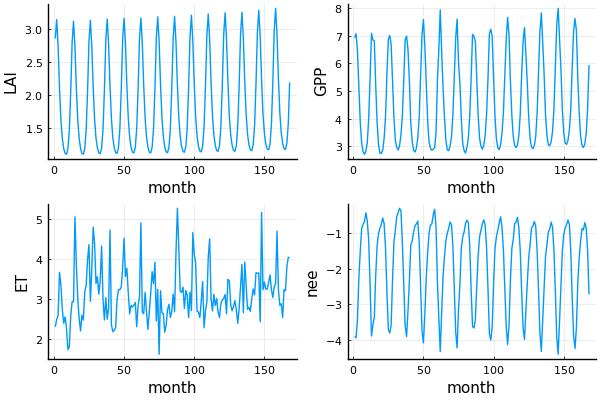

In [23]:
dalec_vars = prognostic_vars(model)
lai_plot = plot(sol[1, 2:model.temporal.NODAYS+1], ylabel=dalec_vars[1], xlabel="month", label=nothing)
gpp_plot = plot(sol[2, 2:model.temporal.NODAYS+1], ylabel=dalec_vars[2], xlabel="month", label=nothing)
et_plot = plot(sol[3, 2:model.temporal.NODAYS+1], ylabel=dalec_vars[3], xlabel="month", label=nothing)
nee_plot = plot(sol[32, 2:model.temporal.NODAYS+1], ylabel=dalec_vars[32], xlabel="month", label=nothing)
plot(lai_plot, gpp_plot, et_plot, nee_plot)